# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 12.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

За основу взят код с семинара на майноре ИАД: http://nbviewer.jupyter.org/github/shestakoff/hse-minor-da-adv/blob/master/2017/seminar1-svm/minor-seminar-svm-proc.ipynb

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

from ipywidgets import IntSlider
from ipywidgets import interactive

In [5]:
from sklearn.datasets import make_classification

Линейно-разделимая выборка:

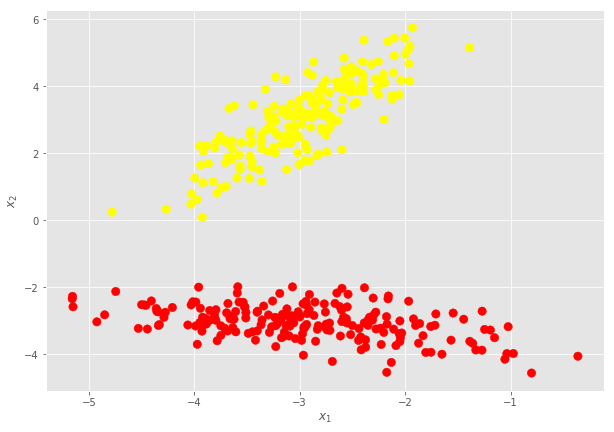

In [3]:
class_sep = 3

X, y = make_classification(n_samples=400, n_features=2, n_informative=2, class_sep=class_sep,
                           n_redundant=0, n_clusters_per_class=1, random_state=5)
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Хорошо разделимая выборка, но не линейно:

In [4]:
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits import mplot3d

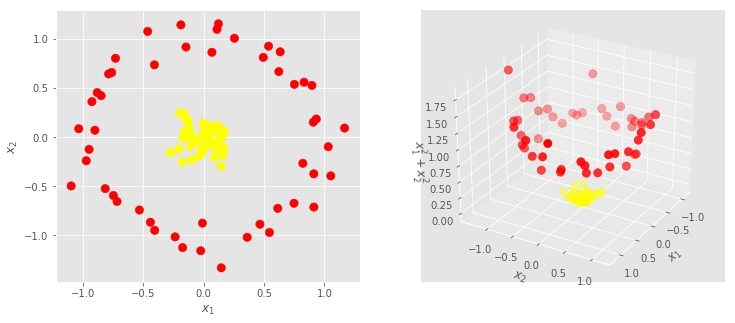

In [5]:
X, y = make_circles(n_samples=100, factor=0.1, 
                    noise=0.1, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)

ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

r = X[:, 0] ** 2 + X[:, 1] ** 2

ax = fig.add_subplot(1, 2, 2)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_1^2 + x_2^2$')

Плохо разделимая выборка:

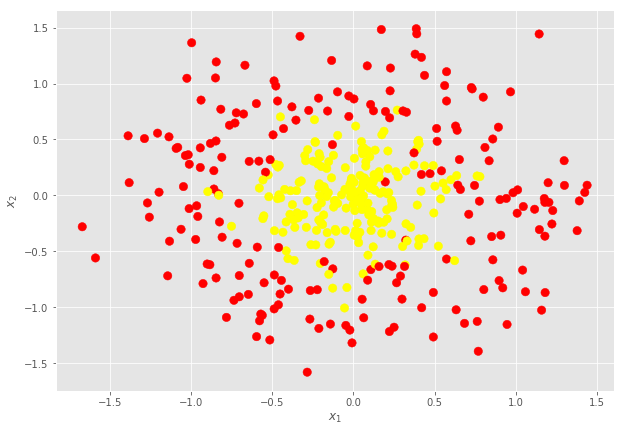

In [6]:
X, y = make_circles(n_samples=400, factor=0.1, 
                    noise=0.3, random_state=123)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

Для изображения разделяющей плоскости используем следующую функцию:

In [7]:
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Линейное ядро для различных параметров $С$:

In [9]:
def lin_svm(C):   
    class_sep = 3
    
    X, y = make_classification(n_samples=400, n_features=2, n_informative=2, class_sep=class_sep,
                               n_redundant=0, n_clusters_per_class=1, random_state=5)
    
    lin_svm = SVC(kernel='linear', C=C).fit(X, y)
    
    # Plotting the splitting hyperplane and support vectors
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(lin_svm)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
                s=200, facecolors='none')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()

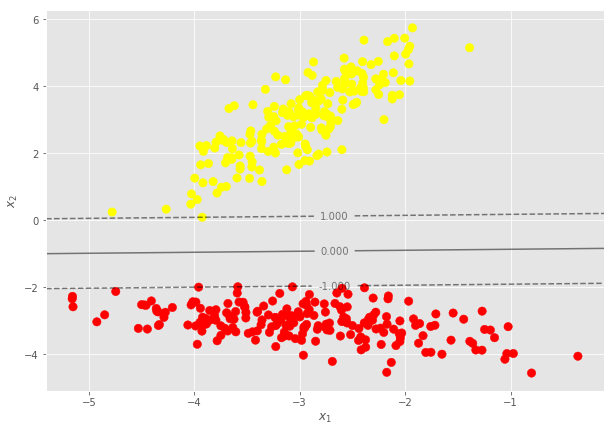

In [10]:
interactive(lin_svm, C=IntSlider(min=1, max=101, value=21, step=20))

Полиномиальное для различных значений $\gamma, d$, и сразу построим для разных $C$ для 3 задания:

In [11]:
def pol_svm(gamma, degree, C):  
    X, y = make_circles(n_samples=400, factor=0.1, 
                        noise=0.25, random_state=123)
    
    pol_svc = SVC(kernel='poly', degree = degree, C=C, gamma=gamma).fit(X, y)
    
    # Plotting the splitting hyperplane and support vectors
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(pol_svc)
    plt.scatter(pol_svc.support_vectors_[:, 0], pol_svc.support_vectors_[:, 1],
                s=200, facecolors='none')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()

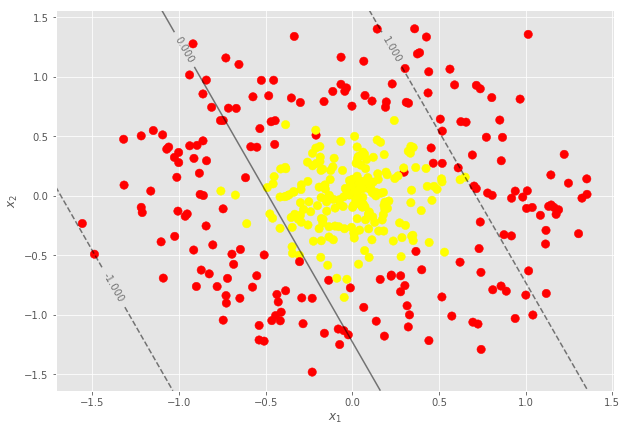

In [12]:
interactive(pol_svm, gamma=IntSlider(min=1, max=21, value=1, step=5),
            degree=IntSlider(min=1, max=5, value=1, step=1),
            C=IntSlider(min=1, max=21, value=1, step=5))

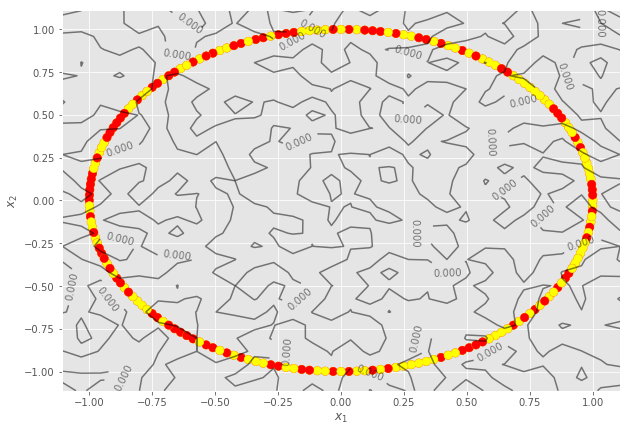

In [13]:
X, y = make_circles(n_samples=400, factor=1, 
                    noise=0, random_state=123)

pol_svc = SVC(kernel='poly', degree = 2, C=6, gamma=1).fit(X, y)

# Plotting the splitting hyperplane and support vectors
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
plot_svc_decision_function(pol_svc)
plt.scatter(pol_svc.support_vectors_[:, 0], pol_svc.support_vectors_[:, 1],
            s=200, facecolors='none')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(pol_svc.predict(X), y)

0.5

Гауссовское для различных значений $\gamma$:

In [16]:
def rbf_svm(gamma, C):  
    X, y = make_circles(n_samples=400, factor=0.1, 
                        noise=0.25, random_state=123)
    
    rbf_svc = SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y)
    
    # Plotting the splitting hyperplane and support vectors
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(rbf_svc)
    plt.scatter(rbf_svc.support_vectors_[:, 0], rbf_svc.support_vectors_[:, 1],
                s=200, facecolors='none')
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()

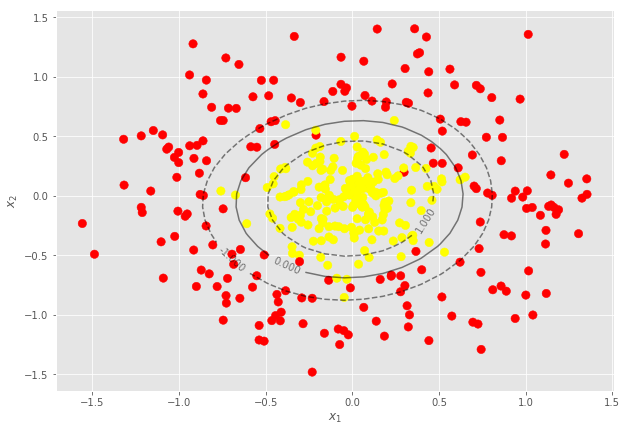

In [17]:
interactive(rbf_svm, gamma=IntSlider(min=1, max=21, value=1, step=5),
            C=IntSlider(min=1, max=21, value=1, step=5))

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

**Ответ:** На виджетах во втором задании все это наглядно показано для обоих вопросов. В целом, чем больше ставить значение гиперпараметров, тем более переобученной будет модель. По этой причине, нужно суметь подобрать оптимальные параметры, чтобы модель хорошо описывала данные и выдавала адекватное значение функционала на тестовой выборке.

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

Небольшая предобработка данных:

In [18]:
data = pd.read_csv('train.csv', sep=',')
data.head()

y = data.iloc[:,0]
data.drop('Activity', axis = 1, inplace=True)
X = data

Разедлим выборку:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=12)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
svc_rbf = SVC(kernel='rbf', gamma=15, coef0=1, C = 1)
svc_rbf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma=15, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
accuracy_score(y_train, svc_rbf.predict(X_train))

1.0

Даже когда сильно штрафуем модель, значение accuracy небольшое:

In [23]:
accuracy_score(y_test, svc_rbf.predict(X_test))

0.53678038379530912

In [24]:
svc_lin = SVC(kernel='linear', C = 1)
svc_lin.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
accuracy_score(y_train, svc_lin.predict(X_train))

0.88959999999999995

Зато линейная модель показывает результат на порядок лучше:

In [26]:
accuracy_score(y_test, svc_lin.predict(X_test))

0.88326226012793174

**Ответ:** Оказалось, что линейная модель в данном случае работает лучше.

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [9]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


Посмотрим на нее:

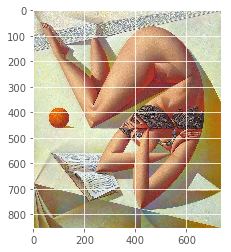

In [10]:
plt.imshow(img);

Для удобства оставим только один канал.

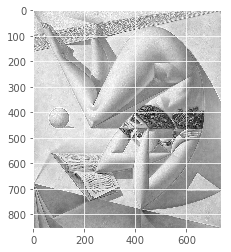

In [11]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

In [12]:
from sklearn.utils.extmath import randomized_svd

In [13]:
def pc_image(nth_component):
    U, Sigma, VT = randomized_svd(img, 
                              n_components=736,
                              n_iter=5,
                              random_state=None)
    S = np.zeros((736,))
    S[nth_component - 1,] = Sigma[nth_component - 1]
    US = U[:,nth_component - 1].dot(Sigma[nth_component - 1]).reshape(-1, 1)
    VT = VT[nth_component - 1].reshape(1,-1)
    plt.imshow(US.dot(VT), cmap='gray')
    plt.show()

Визуализацию можно провести с помощью виджета:

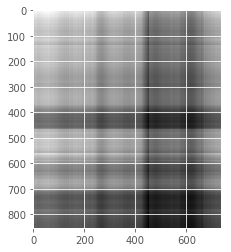

In [14]:
interactive(pc_image, nth_component=IntSlider(min=1, max=736, value=1, step=1))

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


In [35]:
def image_svd(n_components):
    U, Sigma, VT = randomized_svd(img, 
                              n_components=n_components,
                              n_iter=5,
                              random_state=None)
    plt.imshow(U.dot(np.diag(Sigma)).dot(VT), cmap='gray')
    plt.show()

In [11]:
interactive(image_svd, n_components=IntSlider(min=1, max=736, value=1, step=1))

In [13]:
iters = np.arange(1,736)

t_SVD = TruncatedSVD(n_components=735, algorithm='randomized', n_iter=2, random_state=1)
t_SVD.fit(img)
Scores = t_SVD.explained_variance_

plt.figure(figsize=(10,7))
plt.plot(iters, Scores)
plt.xlabel('Components')
plt.ylabel('Explained Variance');

NameError: name 'TruncatedSVD' is not defined

Судя по графику, нам нужно где-то 35-40 главных компонент.

Вес картинки без сжатия:

In [118]:
img.nbytes

627808

Вес картинки со сжатием:

In [82]:
U, Sigma, VT = randomized_svd(img, 
                              n_components=35,
                              n_iter=5,
                              random_state=None)
U.nbytes + Sigma.nbytes + VT.nbytes

445200

Вес картинки уменьшился примерно на треть.

## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

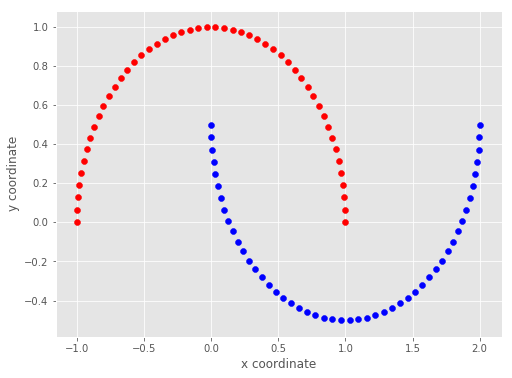

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
def draw_vector(v0, v1, ax=None):
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color = 'green')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

Источник: https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Principal-Components-Rotation

Проекция на одну главную компоненту:

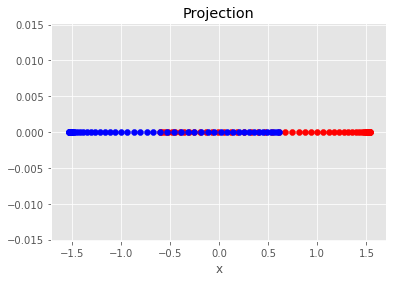

In [17]:
rng = np.random.RandomState(1)


pca1 = PCA(n_components=1, whiten=True)
pca1.fit(X)


# plot principal components
X_pca = pca1.transform(X)



plt.scatter(X_pca[y==0], np.zeros((50,1)), color='red')
plt.scatter(X_pca[y==1], np.zeros((50,1)), color='blue')
plt.xlabel('x') 
plt.title('Projection');

Проекция на две главных компоненты:

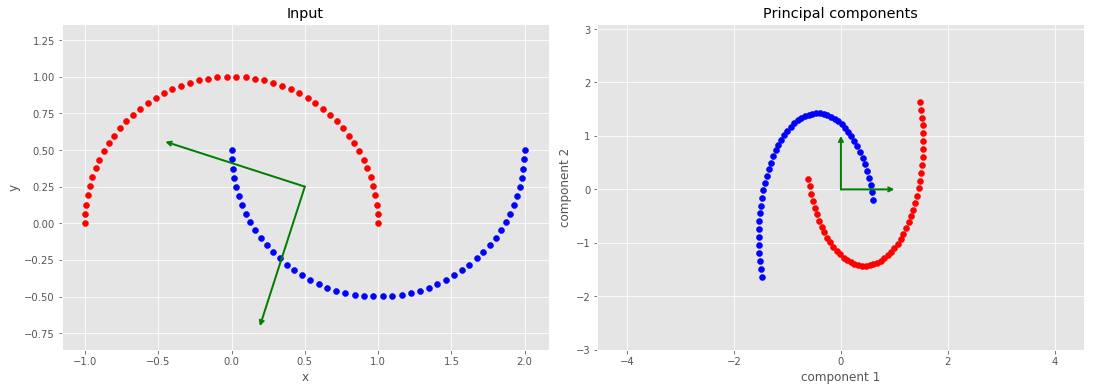

In [18]:
rng = np.random.RandomState(1)


pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[y==0, 0], X[y==0, 1], color='red')
ax[0].scatter(X[y==1, 0], X[y==1, 1], color='blue')



for vector in pca.components_:
    v = vector * 100
    draw_vector(0 + pca.mean_, vector + pca.mean_, ax=ax[0])

ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='Input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='red')
ax[1].scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='blue')

draw_vector([0, 0], [0, 1], ax=ax[1])
draw_vector([0, 0], [1, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='Principal components',
          xlim=(-5, 5), ylim=(-3, 3.1));


### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [30]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [28]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma*mat_sq_dists)

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

Проекция на одну компоненту:

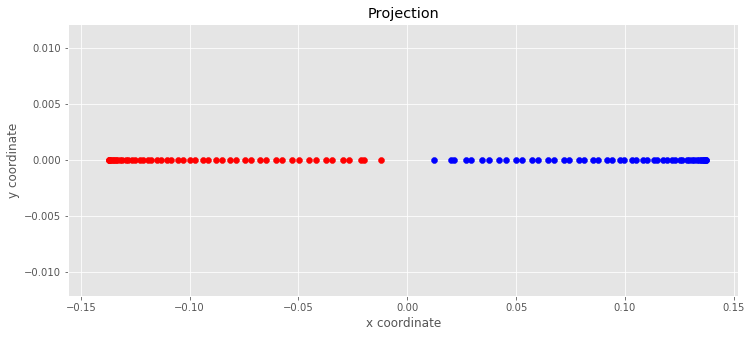

In [41]:
PCA_2 = stepwise_kpca(X, gamma=15, n_components=1)

plt.scatter(PCA_2[y==0, 0], np.zeros((50,1)), color='red')
plt.scatter(PCA_2[y==1, 0], np.zeros((50,1)), color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.title('Projection')

plt.show();

Проекция на две компоненты:

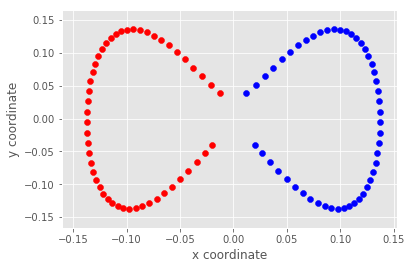

In [423]:
PCA_X = stepwise_kpca(X, gamma=15, n_components=2)

plt.scatter(PCA_X[y==0, 0], PCA_X[y==0, 1], color='red')
plt.scatter(PCA_X[y==1, 0], PCA_X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Ваши мысли о задании:

Гуглится, но нужно немного допилить код из интернета.

### Здесь можете поделиться картинкой